In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from src.Estimation.MLE import MLEstimator
from src.Simulator.SSA import SSASimulator
from src.Plotter.SystemPlotter import SysPlotter

# MLE for BirthDeath Model

In [19]:
from src.Models.models import BirthDeath
model_bd = BirthDeath()
simulator_bd = SSASimulator(model_bd)

parameters = model_bd.getDefaultParameter()
y, t = simulator_bd.run_ssa(np.array([5]), 10000, parameters)

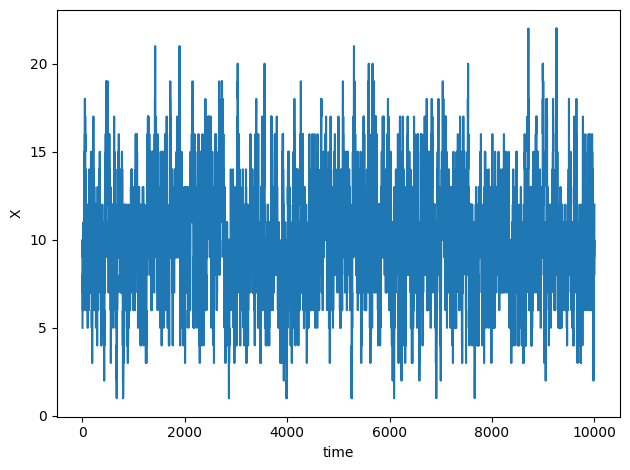

In [20]:
plotter = SysPlotter()
fig = plotter.plotSystem(y, t, model_bd)

/tmp/ipykernel_25138/653699787.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


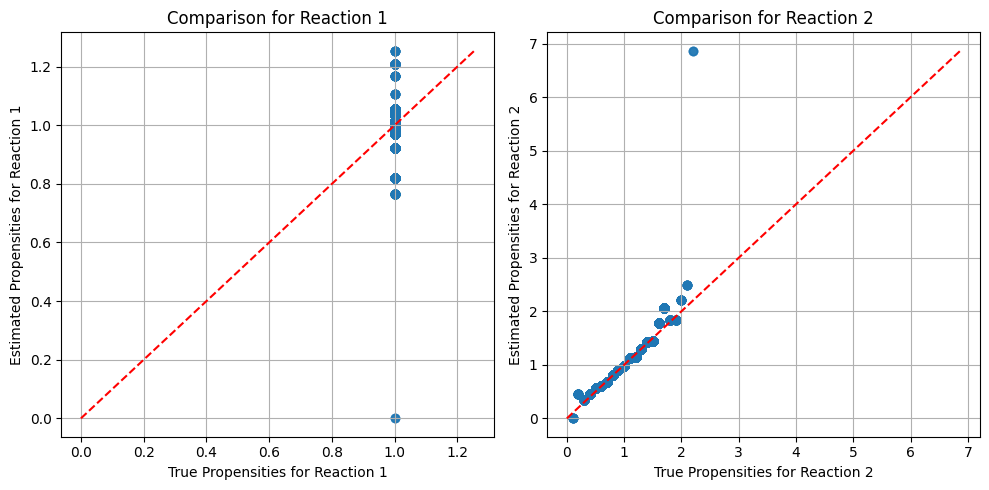

In [21]:
estimator = MLEstimator(model_bd, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()

# MLE for Three State Lotka-Voltera Model


In [27]:
from src.Models.models import ThreeSpeciesModel
model_lv = ThreeSpeciesModel()
simulator_lv = SSASimulator(model_lv)

parameters = model_lv.getDefaultParameter()
y, t = simulator_lv.run_ssa(np.array([80000, 10, 10]), 500, parameters)

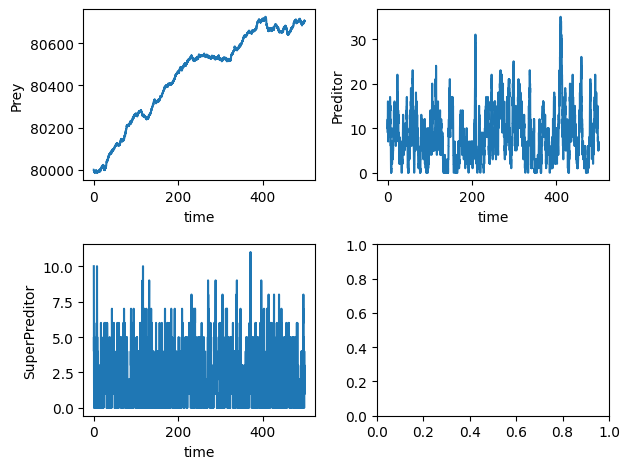

In [28]:
plotter = SysPlotter()
fig = plotter.plotSystem(y, t, model_lv)

/tmp/ipykernel_25138/3620067050.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


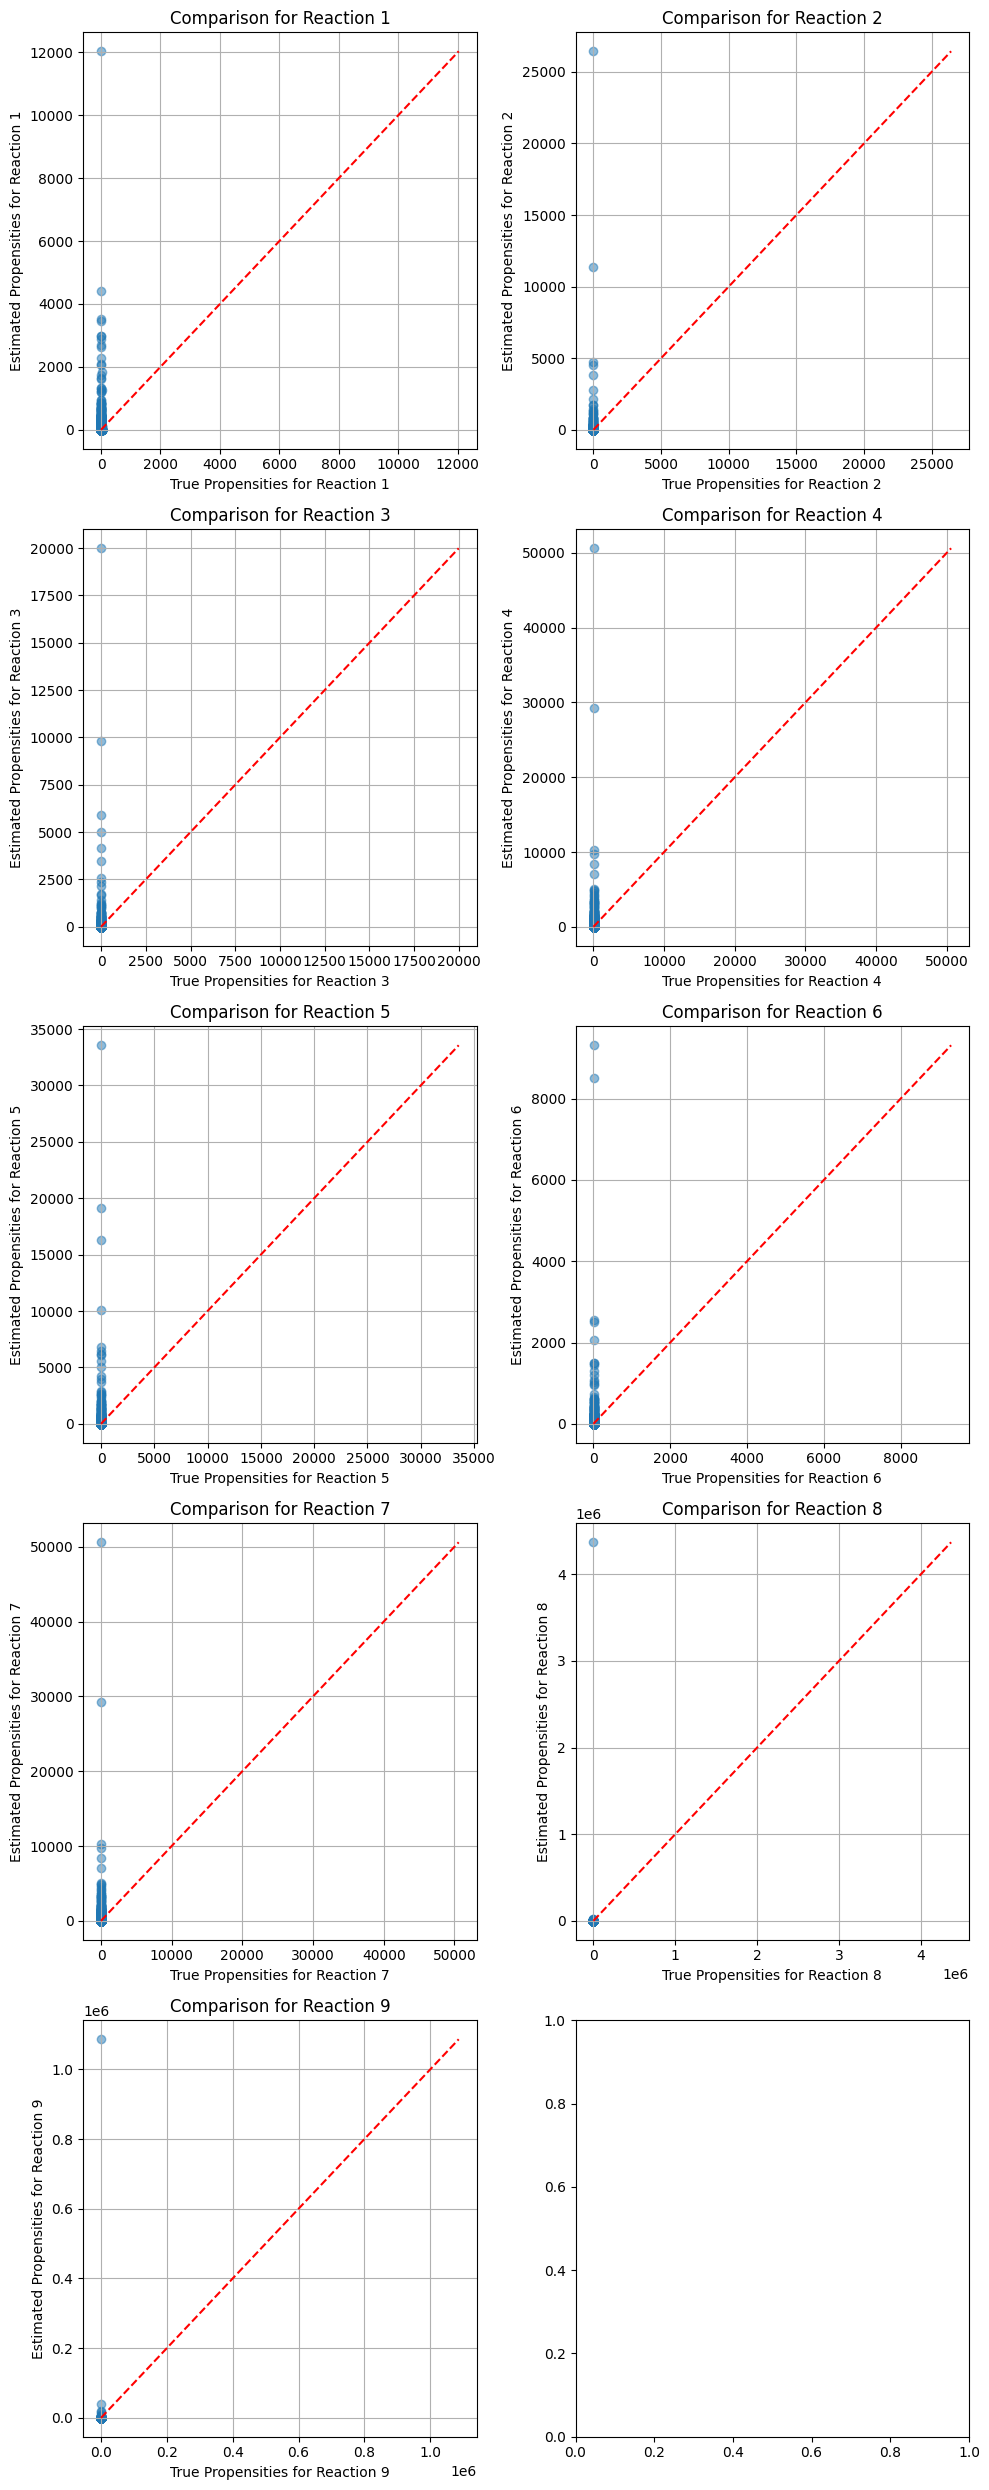

In [29]:
estimator_lv = MLEstimator(model_lv, y, t)
mle_matrix_lv = estimator_lv.computeMLETransitionMatrix()

fig = estimator_lv.plotMLEstimates(mle_matrix_lv)
fig.show()